In [2]:
from astropy.table import Table, vstack
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic
import matplotlib.pyplot as plt
import numpy as np
import matplotlib 
from RegscorePy import *
from collections import OrderedDict
from radial_distribution_funcs import *
from cosmic_calc import * 
from astropy.cosmology import WMAP9

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=20), plt.rc('ytick', labelsize=20)
plt.rcParams['savefig.dpi'] = 100
plt.rc('text',usetex=True)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
np.set_printoptions(precision=3)
figure_save_path = 'figures/radial_dist/'

In [3]:
bin_number=14
bin_edges_areas = 10 ** np.linspace(1.0, np.log10(700), num=bin_number + 1)
areas = np.array([])
for i in range(len(bin_edges_areas[:-1])):
    areas = np.append(areas, (bin_edges_areas[i + 1] ** 2 - bin_edges_areas[i] ** 2) * np.pi)
    

### Total Satellite Sample (all $z$-bins)

In [192]:
sat_z_cut = 1.5
path = 'new_radial_dist_2023/distribution/total_sample_test_pcat_11.0_'+str(sat_z_cut)+'/'
masscut_low = '9.5'
masscut_high = '12.0'
csfq='all'

bin_number=14
bin_edges = np.load(path+'bin_edges.npy')
bin_centers = np.load(path+'bin_centers_fixed.npy')
minus = bin_centers - bin_edges[:-1]
plus = bin_edges[1:] - bin_centers

In [118]:

for sample in ['','sat','bkg']:
    radial_all = np.zeros(bin_number)
    radial_all_err_square = np.zeros(bin_number)
    radial_ssf = np.zeros(bin_number)
    radial_ssf_err_square = np.zeros(bin_number)
    radial_sq = np.zeros(bin_number)
    radial_sq_err_square = np.zeros(bin_number)
    count_central = 0
    
    bin_centers = np.load(path+'bin_centers_fixed.npy')
    for z in [0.4, 0.6, 0.8, 1.0]:
        radial_z_all = combine_deep_fields(field_names,csfq,'all', masscut_low,masscut_high, z, sat_z_cut=sat_z_cut, path=path, sample=sample, bin_number=bin_number)
        print('No. of centrals',z,radial_z_all[2])
        
        count_central += radial_z_all[2]
        radial_all += radial_z_all[0]*radial_z_all[2]
        radial_all_err_square += radial_z_all[1]**2*radial_z_all[2]**2
            
        radial_z_ssf = combine_deep_fields(field_names,csfq,'ssf', masscut_low,masscut_high, z, sat_z_cut=sat_z_cut, path=path, sample=sample, bin_number=bin_number)
        radial_ssf += radial_z_ssf[0]*radial_z_ssf[2]
        radial_ssf_err_square += radial_z_ssf[1]**2*radial_z_ssf[2]**2
            
        radial_z_sq = combine_deep_fields(field_names,csfq,'sq', masscut_low,masscut_high, z, sat_z_cut=sat_z_cut, path=path, sample=sample, bin_number=bin_number)
        radial_sq += radial_z_sq[0]*radial_z_sq[2]
        radial_sq_err_square += radial_z_sq[1]**2*radial_z_sq[2]**2
        
        if sample != '': 
            sample_show = sample+'_'
        else:
            sample_show = ''
            
        np.savetxt(path+'all_field_'+ sample_show + str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_'+csfq+'_'+ str(z) + '_all'+'.txt', (radial_z_all[0],radial_z_all[1]))
        np.savetxt(path+'all_field_'+ sample_show + str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_'+csfq+'_'+ str(z) + '_ssf'+'.txt', (radial_z_ssf[0],radial_z_ssf[1]))
        np.savetxt(path+'all_field_'+ sample_show + str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_'+csfq+'_'+ str(z) + '_sq'+'.txt', (radial_z_sq[0],radial_z_sq[1]))
    
    radial_all = (radial_all/count_central, np.sqrt(radial_all_err_square)/count_central)
    radial_ssf = (radial_ssf/count_central, np.sqrt(radial_ssf_err_square)/count_central)
    radial_sq = (radial_sq/count_central, np.sqrt(radial_sq_err_square)/count_central)
    print('No. of centrals',count_central)
    
    np.savetxt(path+'all_field_'+ sample_show +str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_'+csfq+'_all'+'.txt', radial_all)
    np.savetxt(path+'all_field_'+ sample_show +str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_'+csfq+'_ssf'+'.txt', radial_ssf)
    np.savetxt(path+'all_field_'+ sample_show +str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_'+csfq+'_sq'+'.txt', radial_sq)

No. of centrals 0.4 1125.0
No. of centrals 0.6 1384.0
No. of centrals 0.8 1808.0
No. of centrals 1.0 1695.0
No. of centrals 6012.0
No. of centrals 0.4 1125.0
No. of centrals 0.6 1384.0
No. of centrals 0.8 1808.0
No. of centrals 1.0 1695.0
No. of centrals 6012.0
No. of centrals 0.4 1125.0
No. of centrals 0.6 1384.0
No. of centrals 0.8 1808.0
No. of centrals 1.0 1695.0
No. of centrals 6012.0


### catalog stats figures

In [ ]:
# central galaxy mass offset



# match with C20



In [ ]:
# load in satellite catalogs





In [ ]:
# mass vs z plot





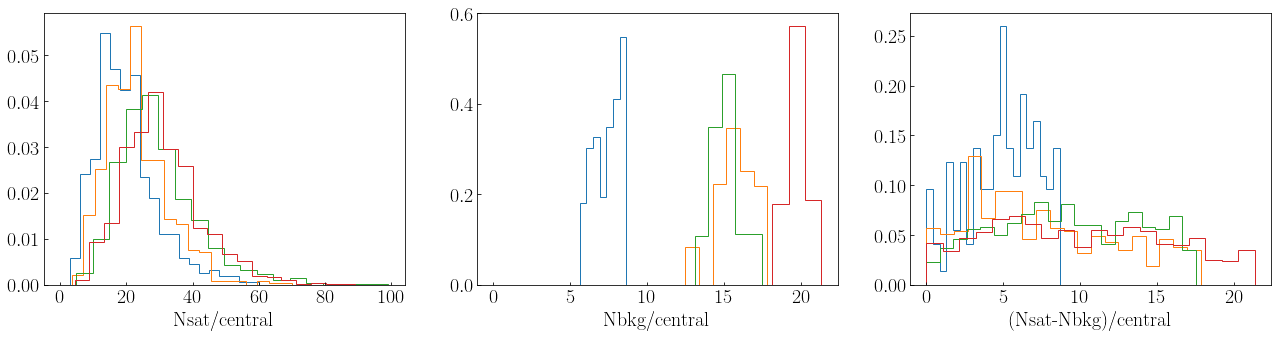

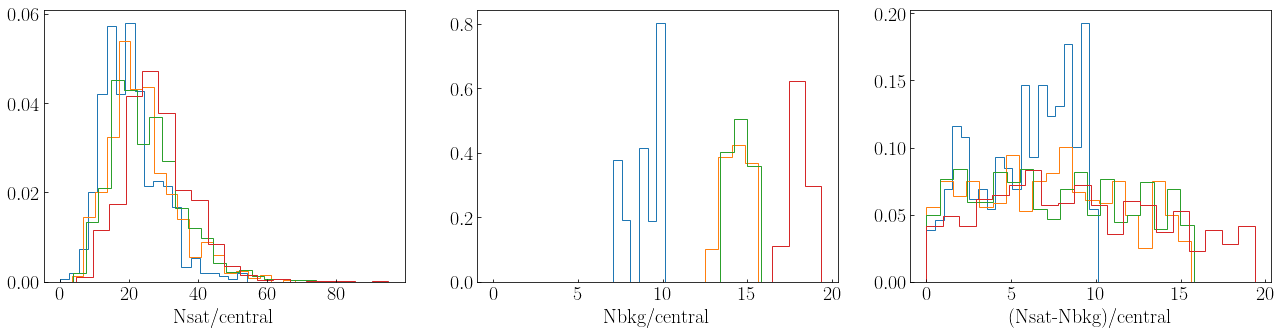

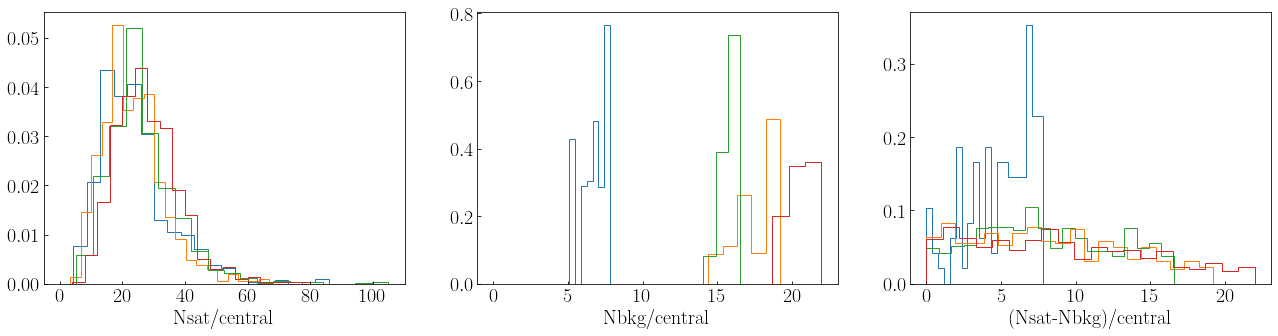

In [193]:
# N/central distribution
hist_show  = ''
for cat_name in ['COSMOS_deep','DEEP_deep','ELAIS_deep']:
    fig, axs = plt.subplots(1, 3, figsize=(22, 5))
    for z in [0.4,0.6,0.8,1.0]:
        cat = Table.read('new_radial_dist_2023/central_cat/isolated_'+cat_name+'_1.5_11.0_'+str(z)+'_massive.positions.fits')
        
        if hist_show == 'volume_norm':
            volumes_central = []
            for gal in cat:
                # cylinder volume
                z_sat_high = gal['Z_COMBINE'] + sat_z_cut * 0.06 * (1 + gal['Z_COMBINE'])
                z_sat_low = gal['Z_COMBINE'] - sat_z_cut * 0.06 * (1 + gal['Z_COMBINE'])
            
                z_test_bin_size = (z_sat_high - z_sat_low)/10
                volume_cylinder = 0
                for z_test in np.arange(z_sat_low,z_sat_high,z_test_bin_size):
                    volume = ( cosmic_calc(z_test+z_test_bin_size) - cosmic_calc(z_test) )*1e9 # in Mpc^3
                    radius_radians = 0.7/ WMAP9.angular_diameter_distance(z_test).value # radian radius at redshift of the central galaxy
                    solid_angle = np.pi*radius_radians**2
                    total_solid_angle = 4*np.pi 
                    volume_cylinder += volume*solid_angle/total_solid_angle
                volumes_central.append(volume_cylinder)
            norm = volumes_central
        else:
            norm = np.ones(len(cat))
        
        axs[0].hist(cat['n_sat']/norm, histtype='step',range=(0,max(cat['n_sat']/norm)),bins=20,density=True)
        axs[1].hist(cat['n_bkg']/norm, histtype='step',range=(0,max(cat['n_bkg']/norm)),bins=20,density=True)
        axs[2].hist((cat['n_sat']-cat['n_bkg'])/norm, histtype='step',range=(0,max(cat['n_bkg']/norm)),bins=20,density=True)
        
    axs[0].set_xlabel('Nsat/central', fontsize=20)
    axs[1].set_xlabel('Nbkg/central', fontsize=20)
    axs[2].set_xlabel('(Nsat-Nbkg)/central', fontsize=20)
    

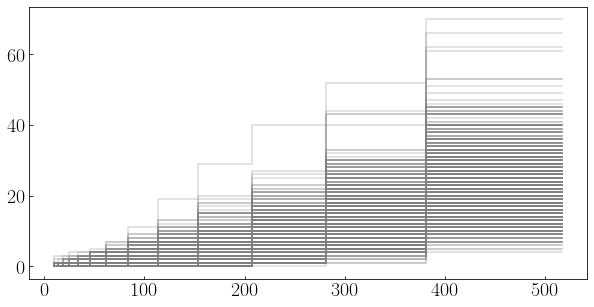

In [189]:
# cumulative sat distribution
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(10, 5))
central_cat = Table.read('new_radial_dist_2023/central_cat/isolated_COSMOS_deep_1.5_11.0_0.6_massive.positions.fits')

for gal in central_cat:
    sat_dist = gal['sat_dist']
    cum_sum = np.cumsum(sat_dist*areas)
    plt.step(bin_edges_areas[:-1],cum_sum,color='grey',alpha=0.3)

### Results Figures

nfw+sersic [1.000e+03 5.701e-06 1.077e-05 5.000e+01 1.050e+00] [2.980e+02 1.347e-06 4.058e-06 1.431e+01 5.648e-01] 2.235416573831852
nfw+sersic [1.000e+03 3.929e-06 6.670e-06 4.328e+01 9.367e-01] [2.963e+02 8.972e-07 3.378e-06 1.522e+01 7.964e-01] 2.1354666054602203
nfw+sersic [6.313e+02 2.582e-06 4.536e-06 5.000e+01 1.080e+00] [2.613e+02 1.028e-06 2.266e-06 1.962e+01 8.497e-01] 2.0016303740992747


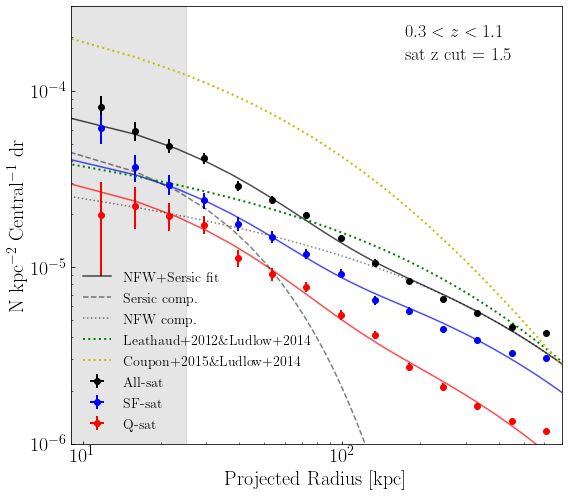

In [119]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 7))
# path = 'new_radial_dist_2023/distribution/total_sample_test_c20_dec04/'

start=4
color=['k','b','r']
sat_type = ['All','SF','Q']
fit_x = np.linspace(2,700,num=100)

count_radial_allz = np.genfromtxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ 'all'+'.txt')
count_radial_sf_allz = np.genfromtxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ 'ssf'+'.txt')
count_radial_q_allz = np.genfromtxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ 'sq'+'.txt')

########
for i, radial in enumerate([count_radial_allz, count_radial_sf_allz, count_radial_q_allz]):
    label='NFW+Sersic fit' if i==0 else ''
    plt.errorbar(bin_centers, radial[0],yerr=radial[1],xerr=0,fmt='o'+color[i],label=sat_type[i]+'-sat',linewidth=2)
    
    popt_allz,pcov_allz,chi2_allz = fit_nfw_sersic(bin_centers,radial[0],radial[1], 2)
    perr_allz = np.sqrt(np.diag(pcov_allz))
    print('nfw+sersic',popt_allz,perr_allz,chi2_allz/(len(bin_edges)-start+1 - len(popt_allz)))
    plt.plot(fit_x,nfw_sersic(fit_x, popt_allz[0],popt_allz[1],popt_allz[2],popt_allz[3],popt_allz[4]),color[i],alpha=0.7,label=label)
        
popt_allz,pcov_allz,chi2_allz = fit_nfw_sersic(bin_centers,count_radial_allz[0],count_radial_allz[1], 2)
plt.plot(fit_x,sersic(fit_x, popt_allz[2],popt_allz[3],popt_allz[4]),'--k',alpha=0.5,label='Sersic comp.')
plt.plot(fit_x,nfw(fit_x,popt_allz[0],popt_allz[1]),':k',alpha=0.5,label='NFW comp.')

# prediction of rs from DM mass distribution 
# median central mass --> halo mass --> rs
rs_range1 = [647] # m_h from Leathaud et al. 2012
rs_range2 = [156] # m_h from Coupon et al. 2015
references = ['Leathaud+2012\&Ludlow+2014','Coupon+2015\&Ludlow+2014']
colors = ['g','y']
norm_to_value = nfw_sersic(bin_centers[-1], popt_allz[0],popt_allz[1],popt_allz[2],popt_allz[3],popt_allz[4])
for i,rs_range in enumerate([rs_range1,rs_range2]):
    for j,rs in enumerate(rs_range):
        norm_guess = 1e-4
        norm = norm_guess/(nfw(fit_x,rs,norm_guess)[-10]/norm_to_value)
        plt.plot(fit_x,nfw(fit_x,rs,norm),':'+colors[i],linewidth=2,label=references[i] if j==0 else'')
        
plt.annotate(r'$0.3<z<1.1$',xy=([0.68,0.93]),xycoords='axes fraction',fontsize=18,color='k')
plt.annotate('sat z cut = '+str(sat_z_cut),xy=([0.68,0.88]),xycoords='axes fraction',fontsize=18,color='k')
# plt.annotate(sfq_method.replace('_',' '),xy=([0.68,0.82]),xycoords='axes fraction',fontsize=18,color='k')

plt.axvspan(9, 25, alpha=0.1, color='k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([9,700])
plt.ylim([1e-6,3e-4])
plt.xlabel('Projected Radius [kpc]', fontsize=20)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
plt.legend(fontsize=14,frameon=False,loc='lower left')
plt.tight_layout()
plt.savefig(figure_save_path+'number_density_allz.png')


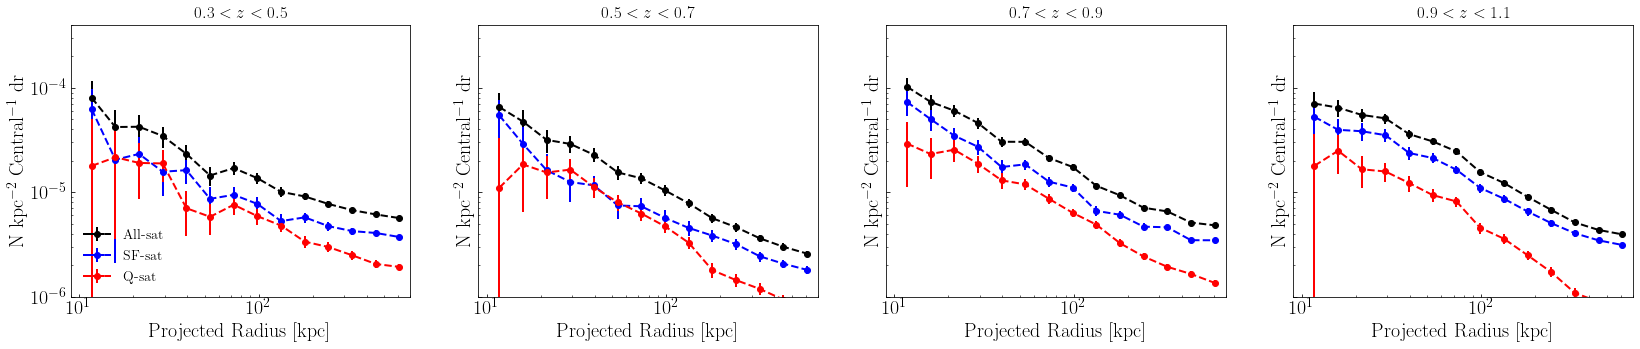

In [120]:
fig, axs = plt.subplots(1, 4, sharex=True,sharey='row', figsize=(28, 5))
color=['k','b','r']
sat_type = ['All','SF','Q']

for z_idx,z in enumerate([0.4, 0.6, 0.8, 1.0]): 
    count_radial_z = np.genfromtxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ str(z) +'_all'+'.txt')
    count_radial_sf_z = np.genfromtxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ str(z) +'_ssf'+'.txt')
    count_radial_q_z = np.genfromtxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ str(z) +'_sq'+'.txt')
    for i, radial in enumerate([count_radial_z, count_radial_sf_z, count_radial_q_z]):
        axs[z_idx].errorbar(bin_centers, radial[0],yerr=radial[1],xerr=0,fmt='o--'+color[i],label=sat_type[i]+'-sat',linewidth=2)

    axs[z_idx].set_xscale('log')
    axs[z_idx].set_yscale('log')
    axs[z_idx].set_xlim([9,700])
    axs[z_idx].set_ylim([1e-6,4e-4])
    
    axs[z_idx].set_title(r'$'+str(round(z-0.1,1))+'<z<'+str(round(z+0.1,1))+'$',fontsize=17)
    axs[z_idx].set_xlabel('Projected Radius [kpc]', fontsize=20)
    axs[z_idx].set_ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
    axs[0].legend(fontsize=14,frameon=False,loc='lower left')


[7.962e-06 7.962e-06 7.962e-06 7.962e-06 7.962e-06 7.962e-06 7.962e-06
 7.962e-06 7.962e-06 7.962e-06 7.962e-06 7.962e-06 7.962e-06 7.962e-06]
[1.17e-05 1.17e-05 1.17e-05 1.17e-05 1.17e-05 1.17e-05 1.17e-05 1.17e-05
 1.17e-05 1.17e-05 1.17e-05 1.17e-05 1.17e-05 1.17e-05]
[1.191e-05 1.191e-05 1.191e-05 1.191e-05 1.191e-05 1.191e-05 1.191e-05
 1.191e-05 1.191e-05 1.191e-05 1.191e-05 1.191e-05 1.191e-05 1.191e-05]
[1.506e-05 1.506e-05 1.506e-05 1.506e-05 1.506e-05 1.506e-05 1.506e-05
 1.506e-05 1.506e-05 1.506e-05 1.506e-05 1.506e-05 1.506e-05 1.506e-05]


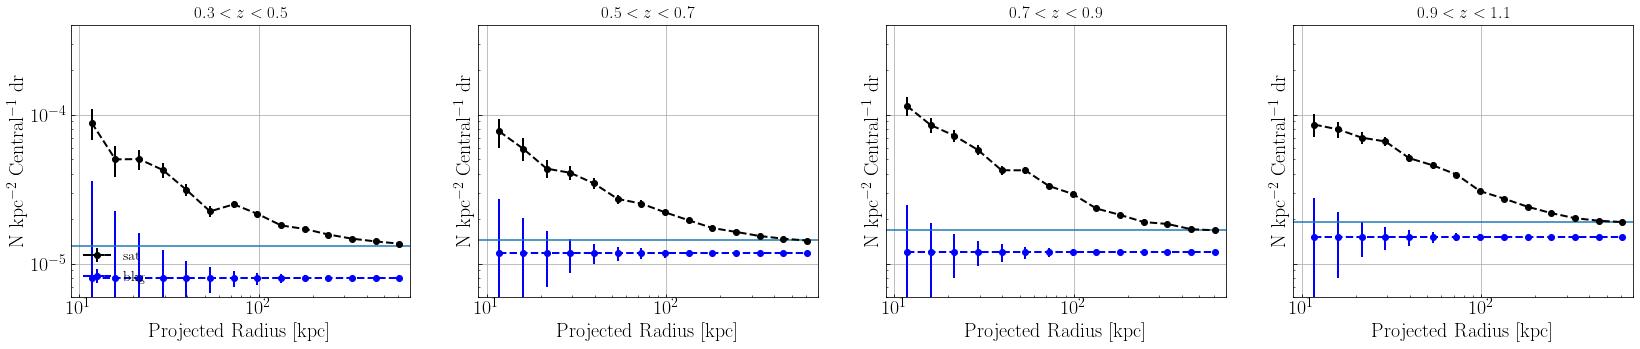

In [125]:
# sat / bkg distribution

fig, axs = plt.subplots(1, 4, sharex=True,sharey='row', figsize=(28, 5))
expected_bkgs = [1.31e-05,1.52e-05,1.67e-05,1.9e-05]

start=4
color=['k','b','r']
sat_type = ['All','SF','Q']

for z_idx,z in enumerate([0.4, 0.6, 0.8, 1.0]): 
    count_radial_z = np.genfromtxt(path  + 'all_field_sat_' + str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ str(z) +'_all'+'.txt')
    count_radial_z_bkg = np.genfromtxt(path + 'all_field_bkg_' + str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ str(z) +'_all'+'.txt')
    print(count_radial_z_bkg[0])
        
    axs[z_idx].errorbar(bin_centers, count_radial_z[0],yerr=count_radial_z[1],xerr=0,fmt='ok--',label='sat',linewidth=2)
    axs[z_idx].errorbar(bin_centers, count_radial_z_bkg[0],yerr=count_radial_z_bkg[1],xerr=0,fmt='ob--',label='bkg',linewidth=2)
    axs[z_idx].plot([9,700],[expected_bkgs[z_idx],expected_bkgs[z_idx]])
    
    axs[z_idx].set_xscale('log')
    axs[z_idx].set_yscale('log')
    axs[z_idx].set_xlim([9,700])
    axs[z_idx].set_ylim([6e-6,4e-4])
    axs[z_idx].set_title(r'$'+str(round(z-0.1,1))+'<z<'+str(round(z+0.1,1))+'$',fontsize=17)
    axs[z_idx].grid()
    
    axs[z_idx].set_xlabel('Projected Radius [kpc]', fontsize=20)
    axs[z_idx].set_ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
    axs[0].legend(fontsize=14,frameon=False,loc='lower left')

[8.812e-05 5.007e-05 5.031e-05 4.254e-05 3.126e-05 2.242e-05 2.500e-05
 2.159e-05 1.805e-05 1.708e-05 1.568e-05 1.470e-05 1.409e-05 1.362e-05]
[7.714e-05 5.918e-05 4.341e-05 4.070e-05 3.453e-05 2.719e-05 2.529e-05
 2.211e-05 1.954e-05 1.734e-05 1.633e-05 1.532e-05 1.471e-05 1.429e-05]
[1.145e-04 8.526e-05 7.228e-05 5.795e-05 4.234e-05 4.229e-05 3.320e-05
 2.937e-05 2.345e-05 2.126e-05 1.902e-05 1.847e-05 1.704e-05 1.674e-05]
[8.569e-05 7.961e-05 7.001e-05 6.603e-05 5.106e-05 4.568e-05 3.963e-05
 3.063e-05 2.734e-05 2.410e-05 2.184e-05 2.019e-05 1.941e-05 1.901e-05]


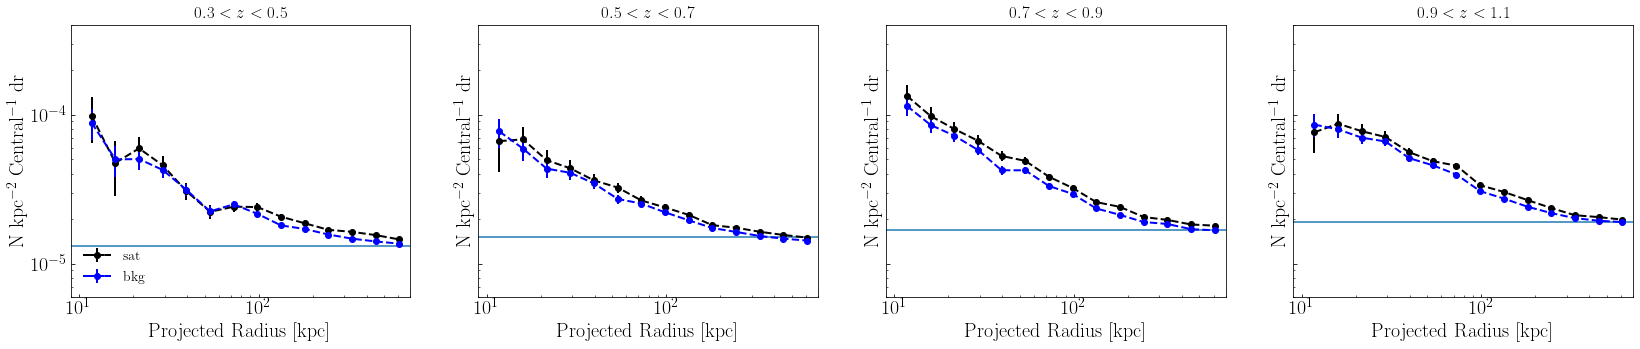

In [109]:
# sat / bkg distribution
path1 = 'new_radial_dist_2023/distribution/total_sample_test_pcat_11.2_'+str(sat_z_cut)+'/'
path2 = 'new_radial_dist_2023/distribution/total_sample_test_pcat_11.0_'+str(sat_z_cut)+'/'

fig, axs = plt.subplots(1, 4, sharex=True,sharey='row', figsize=(28, 5))
expected_bkgs = [1.31e-05,1.52e-05,1.67e-05,1.9e-05]

start=4
color=['k','b','r']
sat_type = ['All','SF','Q']

for z_idx,z in enumerate([0.4, 0.6, 0.8, 1.0]): 
    count_radial_z = np.genfromtxt(path1  + 'all_field_sat_' + str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ str(z) +'_all'+'.txt')
    count_radial_z_bkg = np.genfromtxt(path2 + 'all_field_sat_' + str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ str(z) +'_all'+'.txt')
    print(count_radial_z_bkg[0])
        
    axs[z_idx].errorbar(bin_centers, count_radial_z[0],yerr=count_radial_z[1],xerr=0,fmt='ok--',label='sat',linewidth=2)
    axs[z_idx].errorbar(bin_centers, count_radial_z_bkg[0],yerr=count_radial_z_bkg[1],xerr=0,fmt='ob--',label='bkg',linewidth=2)
    axs[z_idx].plot([9,700],[expected_bkgs[z_idx],expected_bkgs[z_idx]])
    
    axs[z_idx].set_xscale('log')
    axs[z_idx].set_yscale('log')
    axs[z_idx].set_xlim([9,700])
    axs[z_idx].set_ylim([6e-6,4e-4])
    axs[z_idx].set_title(r'$'+str(round(z-0.1,1))+'<z<'+str(round(z+0.1,1))+'$',fontsize=17)
    
    axs[z_idx].set_xlabel('Projected Radius [kpc]', fontsize=20)
    axs[z_idx].set_ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
    axs[0].legend(fontsize=14,frameon=False,loc='lower left')

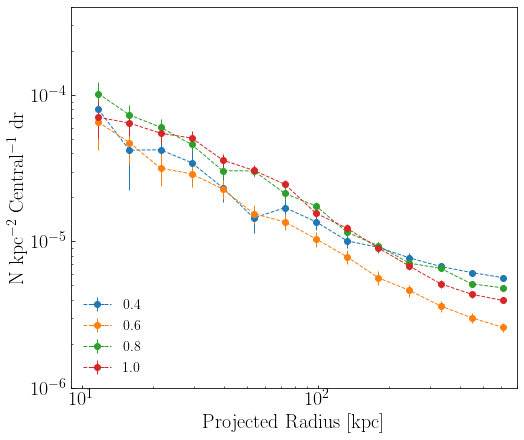

In [142]:
fig, ax = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 7))

start=4
color=['k','b','r']
sat_type = ['All','SF','Q']
fit_x = np.linspace(2,700,num=100)

# adjust = [0,2e-6,0,0]

for z_idx,z in enumerate([0.4, 0.6, 0.8, 1.0]):
    radial = np.genfromtxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ str(z) +'_all'+'.txt')
    ax.errorbar(bin_centers, radial[0],yerr=radial[1],xerr=0,fmt='o--',linewidth=1,label=str(z))
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([9,700])
ax.set_ylim([1e-6,4e-4])
ax.set_xlabel('Projected Radius [kpc]', fontsize=20)
ax.set_ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
ax.legend(fontsize=14,frameon=False,loc='lower left')


evolving mass cut for centrals
artificial test catalog
start with look at N/central and bkg level (centrals catalog)

mnassive gals z<1.5

PDZs of Guillaume's galaxies(include irac detection)
recompute redshift with Guillaume's PDZ 

go to C20, compare z_G and z_C20, check PDZ (bimodal?) and my redshift for massive galaxies (those who changed massses, or not)
bring in IRAC information? check i-IRAC color! mass cut M>[11.0]
also just plot irac vs z_G_6B (or z_ML)

comptute SMF for Guillaume's catalog !!!
also SMF for 6band photometry

Z_BEST distribution

my mass function is lower --> maybe redshift problem --> use pcat redshifts --> avoid pcat z-problems because of lack of IRAC (meaning massive gals may be not estimated correctly) --> modify some of the pcat redshifts --> maybe rerun phosphoros for some of the galaxies (massive ones)

#### Satellite SMF
mass cut for central: 11.3

In [4]:
def combine_deep_smf(path, ssfq, affix, z, masscut_low='7.0',bin_number=50): 
    counts_total = 0
    smf_avg_total = np.zeros(bin_number)
    smf_inf_total = np.zeros(bin_number)
    smf_sup_total = np.zeros(bin_number)
    for cat_name in ['COSMOS_deep','DEEP_deep','ELAIS_deep']:
        smf = np.genfromtxt(path+'smf_'+cat_name+'_0.0_0.7_'+masscut_low+'_all_'+ssfq+'_'+z+'_'+affix+'.txt')
    
        count = smf[0]
        smf_avg = smf[1:bin_number+1]
        smf_inf = smf[bin_number+1:2*bin_number+1]
        smf_sup = smf[2*bin_number+1:3*bin_number+1]
        
        counts_total += count
        smf_avg_total += smf_avg * count
        smf_inf_total += smf_inf * count
        smf_sup_total += smf_sup * count
    
    smf_avg_threefields = smf_avg_total / counts_total
    smf_inf_threefields = smf_inf_total / counts_total
    smf_sup_threefields = smf_sup_total / counts_total
    
    return counts_total, smf_avg_threefields, smf_inf_threefields, smf_sup_threefields


##### define Schehter fitting functions

In [403]:
from scipy.optimize import curve_fit
from bisect import bisect

# schecter function
def schechter(log_m,phi,log_m_s,alpha_s):
    m_s = 10**(log_m_s-10)
    m = 10**(log_m-10)
    return phi*(m/m_s)**(alpha_s)*np.exp(-(m/m_s))

def double_schechter(log_m,log_m_s,phi1,alpha_s1,phi2,alpha_s2):
    m_s = 10**(log_m_s-10)
    m = 10**(log_m-10)
    return (phi1*(m/m_s)**(alpha_s1)+phi2*(m/m_s)**(alpha_s2))*np.exp(-(m/m_s))

def con_double_schec_varysigma(masses,m_s,phi1,alpha_s1,phi2,alpha_s2,z_min):
    intervals = 300
    mrange = np.linspace(8, 12.2, intervals)
    dx = (12.2-8)/intervals
    values = double_schechter(mrange+dx/2,m_s,phi1,alpha_s1,phi2,alpha_s2)  # un-convolved values 
    
    z_min = round(z_min,1)
    arr = np.load('mass_err/mass_err_overall_all_'+str(z_min)+'.npy')
    mass_err_x = arr[0]
    mass_err_y = arr[1]

    # calculate convolved values
    if isinstance(masses, list) or isinstance(masses, np.ndarray):
        con_values = []
        for m in masses:
            sigma_m_var = np.interp(m,mass_err_x,mass_err_y)
            kernel = []  # the gaussian kernel
            for i in range(int(-3*sigma_m_var/dx),int(3*sigma_m_var/dx)+1):
                kernel.append(gaussian(i*dx,0,sigma_m_var))
            kernel = np.array(kernel)
            kernel  = kernel / sum(kernel)
            con_values.append(np.convolve(values,kernel,mode='same')[min(bisect(mrange, m),intervals-1)])
    elif isinstance(masses, float):
        m = masses
        sigma_m_var = np.interp(m,mass_err_x,mass_err_y)
        kernel = []
        for i in range(int(-3*sigma_m_var/dx),int(3*sigma_m_var/dx)+1):
            kernel.append(gaussian(i*dx,0,sigma_m_var))
        kernel = np.array(kernel)
        kernel  = kernel / sum(kernel)
        con_values = np.convolve(values, kernel, mode='same')[min(bisect(mrange, m),intervals-1)]  
    else:
        raise ValueError("wrong value for mass...")
    
    return np.array(con_values)
        
def con_double_schechter(masses,m_s,phi1,alpha_s1,phi2,alpha_s2, sigma_m): # convolved schecter function with a gaussian function
    intervals = 300
    mrange = np.linspace(8, 12.2, intervals)
    dx = (12.2-8)/intervals
    values = double_schechter(mrange+dx/2,m_s,phi1,alpha_s1,phi2,alpha_s2)  # un-convolved values 
    
    # the gaussian kernel (same sigma_m for all masses)
    kernel_const = []
    con_values = []
    for i in range(int(-3*sigma_m/dx),int(3*sigma_m/dx)+1):
        kernel_const.append(gaussian(i*dx,0,sigma_m))
    kernel_const = np.array(kernel_const)
    kernel_const  = kernel_const / sum(kernel_const)
    
    # calculate convolved values
    if isinstance(masses, list) or isinstance(masses, np.ndarray):
        for m in masses:
            con_values.append(np.convolve(values,kernel_const,mode='same')[min(bisect(mrange, m),intervals-1)])
    elif isinstance(masses, float):
        con_values = np.convolve(values, kernel_const, mode='same')[min(bisect(mrange, m),intervals-1)]  
    else:
        raise ValueError("wrong value for mass...")
        
    return np.array(con_values)


def con_schechter(masses,phi,m_s,alpha_s,sigma): # convolved schecter function with a gaussian function
    intervals = 300
    dx = (12.2-8)/intervals
    
    # the gaussian kernel
    kernel = []
    for i in range(int(-3*sigma/dx),int(3*sigma/dx)+1):
        kernel.append(gaussian(i*dx,0,sigma))
    kernel = np.array(kernel)
    kernel  = kernel / sum(kernel)
    
    # calculate convolved values
    con_values = []
    mrange = np.linspace(8, 12.2, intervals)
    values = schechter(mrange+dx/2,phi,m_s,alpha_s)   
    if isinstance(masses, list) or isinstance(masses, np.ndarray):
        for m in masses:
            con_values.append(np.convolve(values,kernel,mode='same')[min(bisect(mrange, m),intervals-1)])
    else:
        m = masses 
        con_values = np.convolve(values, kernel, mode='same')[min(bisect(mrange, m),intervals-1)]           
    return np.array(con_values)

def gaussian(x, mu, sig):
    return 1/(sig*np.sqrt(2*np.pi))*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def con_double_schec_lognormal(masses,m_s,phi1,alpha_s1,phi2,alpha_s2,z_min, mu, sig):
    return con_double_schec_varysigma(masses,m_s,phi1,alpha_s1,phi2,alpha_s2, sigma_m) + gaussian(masses, mu, sig)

#########
#########

# fitting schecter function
def fit_schechter(xdata, ydata, ydata_err, start, end): # phi,m_s,alpha
    popt,pcov = curve_fit(schechter, xdata[start-1:end], ydata[start-1:end], sigma=ydata_err[start-1:end],p0=[2e-4,2.2e+04,-1.75])
    res = ydata - schechter(xdata, *popt)
    chi2_ = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2_

def fit_schechter_con(xdata, ydata, ydata_err, start, end, sigma_m): # phi,m_s,alpha,sigma_m
    popt,pcov = curve_fit(con_schechter, xdata[start-1:end], ydata[start-1:end], sigma=ydata_err[start-1:end],p0=[2e-4,11,-1.5,sigma_m],bounds=([0,10,-2,sigma_m-0.00000001],[1e-2,12,2,sigma_m]),method='trf',absolute_sigma=True)
    res = ydata - con_schechter(xdata, *popt)
    chi2_ = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2_

def fit_double_schechter(xdata, ydata, ydata_err, start, end): # m_s,phi1,alpha_s1,phi2,alpha_s2
    popt,pcov = curve_fit(double_schechter, xdata[start-1:end], ydata[start-1:end], sigma=ydata_err[start-1:end],p0=[11,2e-1,-0.5,2e-1,-1.5],bounds=([10,0,-2,0,-2],[12,20,2,20,0]))
    res = ydata - double_schechter(xdata, *popt)
    chi2_ = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2_

def fit_double_schechter_con(xdata, ydata, ydata_err, start, end, sigma_m, double_fit=True): # log_m_s,phi1,alpha_s1,phi2,alpha_s2,sigma_m
    if double_fit: # double schechter fit
        p0_fit = [11,2e-1,-0.5,2e-1,-1.5,sigma_m]
        bounds_low_fit = [10.4,0,-2,0,-2,sigma_m-0.00001]
        bounds_high_fit = [12,20,4,20,0,sigma_m+0.00001]
    else:  # reduce to single schechter fit
        p0_fit = [11,2e-1,-0.5,0,0,sigma_m]
        bounds_low_fit = [10.4,0,-2,0,0,sigma_m-0.00001]
        bounds_high_fit = [12,1e1,4,1e-15,1e-10,sigma_m+0.00001]
        
    popt,pcov = curve_fit(con_double_schechter, xdata[start-1:end], ydata[start-1:end], sigma=ydata_err[start-1:end],p0=p0_fit,bounds=(bounds_low_fit,bounds_high_fit))
    res = ydata - con_double_schechter(xdata, *popt)
    chi2_ = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2_

def fit_double_schec_varysigma_con(xdata, ydata, ydata_err, start, end, zmin, double_fit=True): # log_m_s,phi1,alpha_s1,phi2,alpha_s2, (z_min, z_max)
    if double_fit: # double schechter fit
        p0_fit = [10.8,1,-0.5,2e-1,-1.5,zmin]
        bounds_low_fit = [10.4,0,-2,0,-2,zmin-0.00001]
        bounds_high_fit = [12,20,4,20,0,zmin+0.00001]
    else:  # reduce to single schechter fit
        p0_fit = [11,2e-1,-0.5,0,0,zmin]
        bounds_low_fit = [10.4,0,-2,0,0,zmin-0.00001]
        bounds_high_fit = [12,2e1,4,1e-15,1e-10,zmin+0.00001]
        
    popt,pcov = curve_fit(con_double_schec_varysigma, xdata[start-1:end], ydata[start-1:end], sigma=ydata_err[start-1:end],p0=p0_fit,bounds=(bounds_low_fit,bounds_high_fit))
    res = ydata - con_double_schec_varysigma(xdata, *popt)
    chi2_ = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2_

def fit_double_schec_lognormal(xdata, ydata, ydata_err, start, end, zmin, mu, sig, double_fit=True):
    if double_fit: # double schechter fit
        p0_fit = [10.8,1,-0.5,2e-1,-1.5,zmin,11.0,0.2]
        bounds_low_fit = [10.4,0,-2,0,-2,zmin-0.00001,10.8,0.2-0.00001]
        bounds_high_fit = [12,20,4,20,0,zmin+0.00001,11.2,0.2+0.00001]
    else:  # reduce to single schechter fit
        p0_fit = [11,2e-1,-0.5,0,0,zmin,11.0,0.2]
        bounds_low_fit = [10.4,0,-2,0,0,zmin-0.00001,10.8,0.2-0.00001]
        bounds_high_fit = [12,2e1,4,1e-15,1e-10,zmin+0.00001,11.2,0.2+0.00001]
        
    popt,pcov = curve_fit(con_double_schec_lognormal, xdata[start-1:end], ydata[start-1:end], sigma=ydata_err[start-1:end],p0=p0_fit,bounds=(bounds_low_fit,bounds_high_fit))
    res = ydata - fit_double_schec_lognormal(xdata, *popt)
    chi2_ = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2_

In [39]:
# basic parameters
z_mins = [0.2,0.5,0.8,1.1]
z_maxs = [0.5,0.8,1.1,1.5]

masscut_low = 7.5
masscut_high = 13.0
num_bins = 50 # number of bin edges
m_bin_left_edges = np.linspace(masscut_low, masscut_high, num=num_bins+1)[:-1]

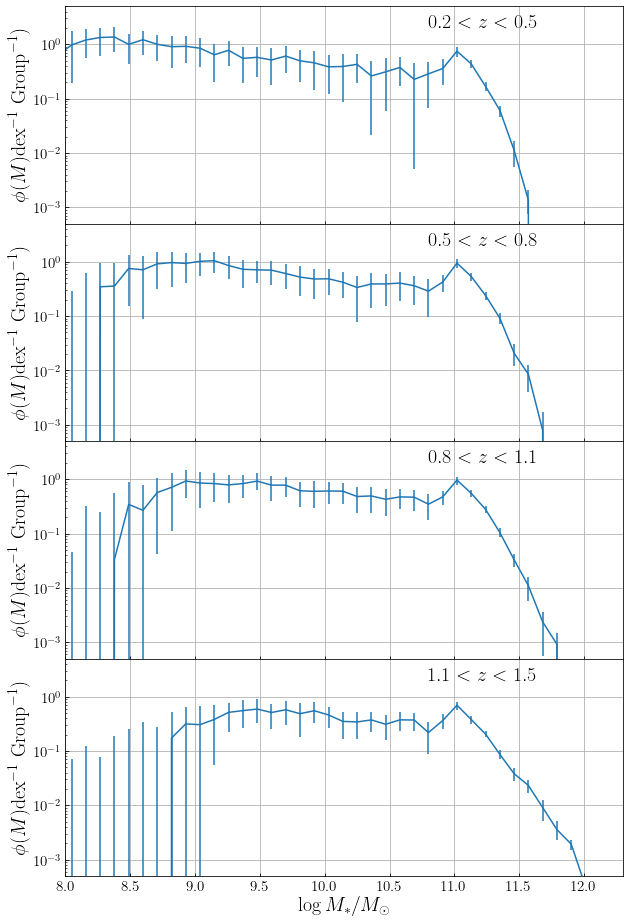

In [37]:
# plot SMF

fig, axs = plt.subplots(4, 1, figsize = (10, 16),sharex=True,sharey=True)
q_colors = ['lightsalmon','red','brown','maroon']
sf_colors = ['cornflowerblue','blue','darkblue','midnightblue']
all_colors  = ['lightgray','darkgray','gray','black']
color_sets = [all_colors, sf_colors, q_colors]

ssfq='all'
count_type = 'sat'

fit_params = []
fit_params_err = []
for i,z in enumerate(z_mins):   
    n_centrals, smf_avg, smf_inf, smf_sup = combine_deep_smf('smf_pcat/test_smf_new_cat/', ssfq, count_type, str(z), masscut_low=str(masscut_low),bin_number=num_bins)
    axs[i].errorbar(m_bin_left_edges, smf_avg,yerr=[smf_avg-smf_inf,smf_sup-smf_avg],label=str(z))  
    
#     y_fitting = smf_avg/n_centrals
#     y_fitting_err = (smf_avg-smf_inf)/n_centrals
    
#     popt, pcov, chi2_ = fit_double_schechter_con(m_bin_left_edges, y_fitting*1e3, y_fitting_err, 5,-5,0.15,double_fit=False)
#     fit_params.append(popt)
#     fit_params_err.append(np.sqrt(np.diag(pcov))) 

    axs[i].set_ylabel(r'$\phi(M)\mathrm{dex}^{-1} ~\mathrm{Group}^{-1})$',fontsize=20)
    axs[i].set_yscale('log')
    axs[i].set_xlim([8,12.3])
    axs[i].set_ylim([5e-4,5])
    axs[i].annotate('$'+str(round(z_mins[i],1))+'<z<'+str(round(z_maxs[i],1))+'$',xy=([0.65,0.9]),xycoords='axes fraction',fontsize=20,color='k')
    axs[i].grid(True)
    
fig.subplots_adjust(wspace=0, hspace=0)
axs[3].set_xlabel('$\log M_*/M_\odot$',fontsize=20)

np.save('fit_param_sat_'+ssfq, np.array(fit_params))
np.save('fit_param_err_sat_'+ssfq, np.array(fit_params_err))

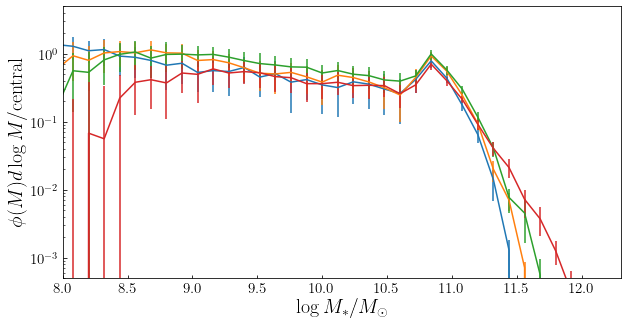

In [440]:
# plot SMF

fig, axs = plt.subplots(1, 1, figsize = (10, 5),sharex=True)
q_colors = ['lightsalmon','red','brown','maroon']
sf_colors = ['cornflowerblue','blue','darkblue','midnightblue']
all_colors  = ['lightgray','darkgray','gray','black']
color_sets = [all_colors, sf_colors, q_colors]

z_mins = [0.2,0.5,0.8,1.1]
z_maxs = [0.5,0.8,1.1,1.5]

num_bins = 50 # number of bin edges
m_bin_left_edges = np.linspace(masscut_low, masscut_high, num=num_bins+1)[:-1]
ssfq='all'
count_type = 'sat'
print(masscut_low, masscut_high)

fit_params = []
fit_params_err = []
for i,z in enumerate(z_mins):   
    n_centrals, smf_avg, smf_inf, smf_sup = combine_deep_smf('smf_pcat/test_smf_new_cat/', ssfq, count_type, str(z), masscut_low=str(masscut_low),bin_number=num_bins)
    
    axs.errorbar(m_bin_left_edges, smf_avg,yerr=[smf_avg-smf_inf,smf_sup-smf_avg],label=str(z))  
    axs.set_ylabel(r'$\phi(M)\mathrm{dex}^{-1} ~\mathrm{Group}^{-1})$',fontsize=20)
    axs.set_yscale('log')
    axs.set_xlim([8,12.3])
    axs.set_ylim([5e-4,5])
    ax.grid(True)
    
fig.subplots_adjust(wspace=0, hspace=0)
axs.set_xlabel('$\log M_*/M_\odot$',fontsize=20)

np.save('fit_param_sat_'+ssfq, np.array(fit_params))
np.save('fit_param_err_sat_'+ssfq, np.array(fit_params_err))

In [ ]:
# plot SMF on different central mass cut







[[ 1.200e+01  8.119e-03 -1.859e-01  9.933e-16  1.000e-10  1.500e-01]
 [ 1.200e+01  8.116e-03 -9.632e-02  8.031e-16  1.000e-10  1.500e-01]
 [ 1.144e+01  1.128e-02  7.705e-02  4.095e-17  1.000e-10  1.500e-01]]


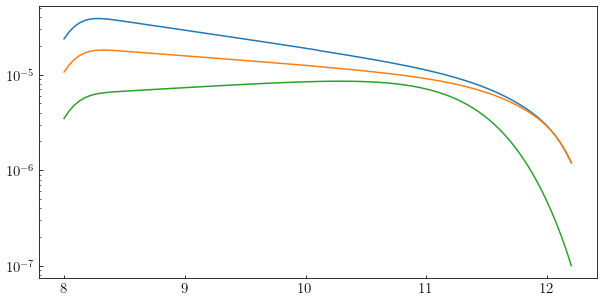

In [338]:
# fitted sat SMFs

fig, axs = plt.subplots(1, 1, figsize = (10, 5),sharex=True)

arr = np.load('fit_param_sat_all.npy')
print(arr)
for i in np.arange(3):
    x_plot = np.linspace(8,12.2,100)
    y_plot = con_double_schechter(x_plot, arr[i][0], arr[i][1]/1e3, arr[i][2],arr[i][3]/1e3, arr[i][4],arr[i][5])

    plt.plot(x_plot,y_plot)
plt.yscale('log')

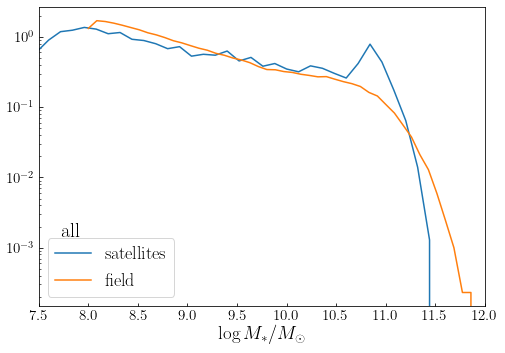

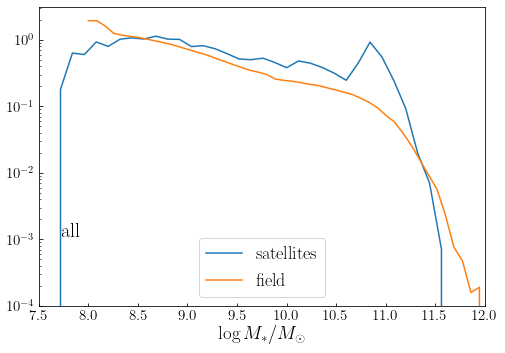

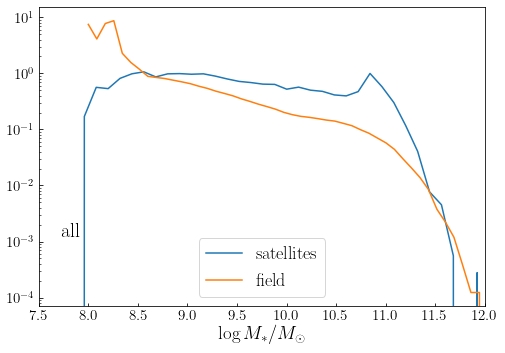

In [426]:
# compare to the field values

z_mins = [0.2,0.5,0.8,1.1]
z_maxs = [0.5,0.8,1.1,1.5]

num_bins = 50 # number of bin edges
m_bin_left_edges = np.linspace(masscut_low, masscut_high, num=num_bins+1)[:-1]
ssfq='all'
count_type = 'sat'

fit_params = []
fit_params_err = []
for i,z in enumerate(z_mins[:-1]):   
    bins_field = np.linspace(8,12.2,50)[:-1]
    smf_field = np.load('pcat_smf_nonir_'+ssfq+'_'+str(z_mins[i])+'_'+str(z_maxs[i])+'.npy')[0]
    
    ssfq = 'all'
    bins_smf = np.linspace(7.0, 13.0, num=21)[:-1]
    smf_sat = combine_deep_smf('smf_pcat/test_smf_new_cat/', ssfq, count_type, str(z), masscut_low=str(masscut_low),bin_number=num_bins)[1]
    
    fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 5.5))
    
    plt.plot(m_bin_left_edges,smf_sat,label='satellites')
    plt.plot(bins_field,smf_field*60,label='field')
    plt.annotate(ssfq,xy=([0.05,0.23]),xycoords='axes fraction',fontsize=20,color='k')
    
    plt.xlim([7.5,12])
    plt.yscale('log')
    plt.legend(fontsize=18)
    plt.xlabel('$\log M_*/M_\odot$',fontsize=19)
    plt.ylabel('arbitrary unit',fontsize=19)

number of centrals 1955.0
number of bkgs 1955.0
number of centrals 1955.0


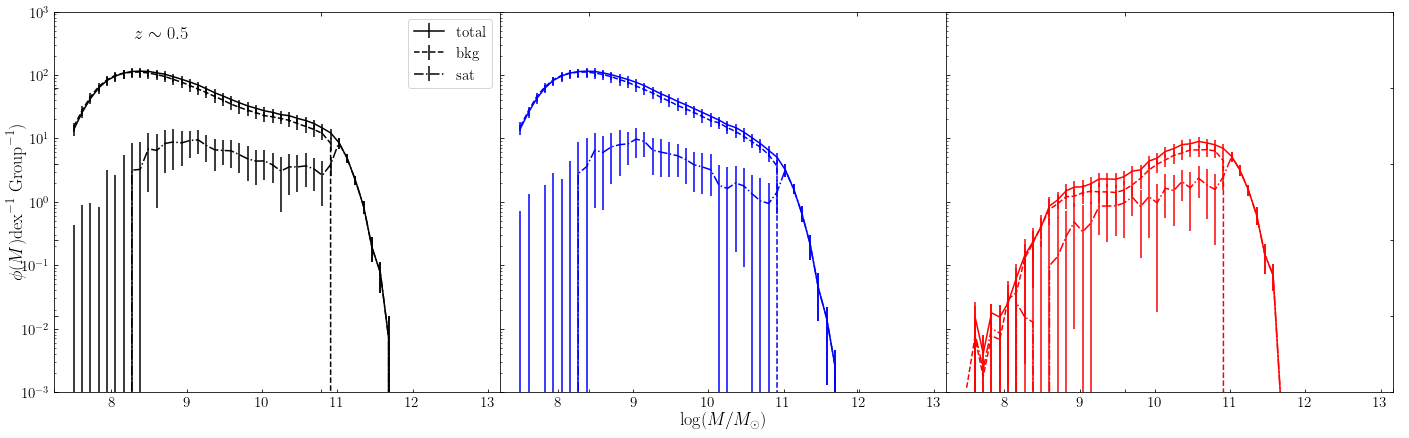

In [40]:
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(24,7))

num_bins = 50 # number of bin edges
bin_edges = m_bin_left_edges = np.linspace(masscut_low, masscut_high, num=num_bins+1)[:-1]
bin_size = bin_edges[1] - bin_edges[0]

z=0.5
low_r='0.0'; high_r='0.7'
path = 'smf_pcat/test_smf_new_cat/'

#load data
all_total = combine_deep_smf(path, 'all', 'total', str(z), masscut_low=str(masscut_low),bin_number=num_bins)
all_bkg = combine_deep_smf(path, 'all', 'bkg', str(z), masscut_low=str(masscut_low),bin_number=num_bins)
all_sat = combine_deep_smf(path, 'all', 'sat', str(z), masscut_low=str(masscut_low),bin_number=num_bins)

sf_total = combine_deep_smf(path, 'ssf', 'total', str(z), masscut_low=str(masscut_low),bin_number=num_bins)
sf_bkg = combine_deep_smf(path, 'ssf', 'bkg', str(z), masscut_low=str(masscut_low),bin_number=num_bins)
sf_sat = combine_deep_smf(path, 'ssf', 'sat', str(z), masscut_low=str(masscut_low),bin_number=num_bins)

q_total = combine_deep_smf(path, 'sq', 'total', str(z), masscut_low=str(masscut_low),bin_number=num_bins)
q_bkg = combine_deep_smf(path, 'sq', 'bkg', str(z), masscut_low=str(masscut_low),bin_number=num_bins)
q_sat = combine_deep_smf(path, 'sq', 'sat', str(z), masscut_low=str(masscut_low),bin_number=num_bins)

# all
print('number of centrals',all_total[0])
print('number of bkgs',all_bkg[0])
print('number of centrals',all_sat[0])

error_all = [(all_total[1]-all_total[2])/bin_size, (all_total[3]-all_total[1])/bin_size]
error_bkg = [(all_bkg[1]-all_bkg[2])/bin_size, (all_bkg[3]-all_bkg[1])/bin_size]
error_sat = [(all_sat[1]-all_sat[2])/bin_size, (all_sat[3]-all_sat[1])/bin_size]
axs[0].errorbar(bin_edges, all_total[1]/bin_size,yerr=error_all,fmt='k',label='total')
axs[0].errorbar(bin_edges, all_bkg[1]/bin_size,yerr=error_bkg,fmt='--k',label='bkg')
axs[0].errorbar(bin_edges, all_sat[1]/bin_size,yerr=error_sat,fmt='-.k',label='sat')
axs[0].annotate(r'$z\sim'+str(z)+'$',xy=([0.18,0.93]),xycoords='axes fraction',fontsize=18,color='k')

#sf
error_sf = [(sf_total[1]-sf_total[2])/bin_size, (sf_total[3]-sf_total[1])/bin_size]
error_sf_bkg = [(sf_bkg[1]-sf_bkg[2])/bin_size, (sf_bkg[3]-sf_bkg[1])/bin_size]
error_sf_sat = [(sf_sat[1]-sf_sat[2])/bin_size, (sf_sat[3]-sf_sat[1])/bin_size]
axs[1].errorbar(bin_edges, sf_total[1]/bin_size,yerr=error_sf,fmt='b')
axs[1].errorbar(bin_edges, sf_bkg[1]/bin_size,yerr=error_sf_bkg,fmt='--b')
axs[1].errorbar(bin_edges, sf_sat[1]/bin_size,yerr=error_sf_sat,fmt='-.b')

#q
error_q = [(q_total[1]-q_total[2])/bin_size, (q_total[3]-q_total[1])/bin_size]
error_q_bkg = [(q_bkg[1]-q_bkg[2])/bin_size, (q_bkg[3]-q_bkg[1])/bin_size]
error_q_sat = [(q_sat[1]-q_sat[2])/bin_size, (q_sat[3]-q_sat[1])/bin_size]

axs[2].errorbar(bin_edges, q_total[1]/bin_size,yerr=error_q,fmt='r')
axs[2].errorbar(bin_edges, q_bkg[1]/bin_size,yerr=error_q_bkg,fmt='--r')
axs[2].errorbar(bin_edges, q_sat[1]/bin_size,yerr=error_q_sat,fmt='-.r')

axs[0].set_yscale('log')
axs[0].set_ylim([1e-3,1e3])
axs[0].legend(fontsize=15)
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
plt.xlabel(r'$\log(M/M_\odot)$', fontsize=18)
plt.ylabel(r'$\phi(M)\mathrm{dex}^{-1} ~\mathrm{Group}^{-1})$', fontsize=18)
plt.show()

In [60]:
# check the overall mass function




#### spatial completeness 

#### catalog from Angelo

In [147]:
cat = Table.read('/Users/lejay/research/massive_gals/cluster_cats/COSMOS_z005_R3000_sig2_N100_specz_241107.fits')

# select centrals
cluster_IDs = np.unique(cat['cluster_ID'])

for cluster_ID in cluster_IDs:
    cat_cluster = cat[cat['cluster_ID'] == cluster_ID]
    cat_cluster = cat_cluster[cat_cluster['mem_prob']>0.15]
    central_gal = cat_cluster[cat_cluster['mem_prob']==100]
    print(cluster_ID,central_gal['ID'][0],len(cat_cluster)-1)

DUD_103 42094416122372119 112
DUD_104 43163553741434914 179
DUD_62 44218380529459079 62
DUD_72 44223470065698963 76
DUD_74 43159022550933820 114
DUD_77 42089876341945470 59
DUD_78 43159026845895392 136
DUD_82 43158876522059780 170
DUD_83 44223186597867377 72
DUD_89 43158580169290315 170
DUD_96 43158335356161222 69
DUD_97 44222499403111638 115


#### speed test on cosmological calculators

In [252]:
from cosmic_calc import *
from astropy.cosmology import *
from astropy.cosmology import WMAP9
import time

In [265]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
cosmo.comoving_volume(1)

<Quantity 1.511e+11 Mpc3>

In [245]:
t1 = time.time()
v = []
for z in np.arange(0,20,0.01):
    v.append(cosmo.comoving_volume(z).value)
t2 = time.time()
print(t2-t1)

0.13830184936523438


In [246]:
t1 = time.time()
v2 = []
for z in np.arange(0,20,0.01):
    v2.append(cosmic_calc(z,H0=70,WM=0.3,WV=0.7))
t2 = time.time()
print(t2-t1)

4.75600528717041


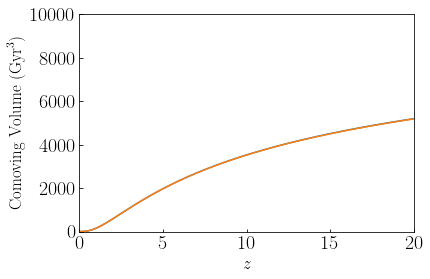

In [248]:
plt.plot(np.arange(0,20,0.01),np.array(v)/1e9)
plt.plot(np.arange(0,20,0.01),np.array(v2))

plt.xlim(0,20)
plt.ylim(0,10000)
plt.xlabel('$z$',fontsize=17)
plt.ylabel('Comoving Volume ($\mathrm{Gyr}^3$)',fontsize=17)
plt.show()

In [264]:
# check (proper scale) kpc-->arcsec scale

cosmo2 = FlatLambdaCDM(H0=70, Om0=0.3)
print(1/cosmo2.arcsec_per_kpc_proper(1).value)

dis = WMAP9.angular_diameter_distance(1).value
print(1/3600/180*np.pi*dis*1e3)

8.008707025690136
8.152313264896698


In [272]:
# angular size in degrees for 700 kpc circle

r_iso = 0.7 # Mpc
print(r_iso/cosmo.angular_diameter_distance(1).value/np.pi*180)
print(r_iso*1e3*cosmo.arcsec_per_kpc_proper(1).value/3600)

0.024279130678736313
0.024279130678736313


In [359]:
# cat = Table.read('/Users/lejay/research/lephare_dev/my_code/graham_output_cats_new/pcat_COSMOS_deep_cat_out_nomaglimit_nonir_il_nz_prior_formass_sfq_added.fits')
cat = Table.read('/Users/lejay/Desktop/COSMOS_galaxies_241104.fits')
cat_name = 'COSMOS'

In [360]:
zkeyname = 'Z_COMBINE'
mass_keyname = 'MASS_MED'
id_keyname = 'ID'
ra_key = 'RA'
dec_key = 'DEC'
z_min = 1.1
z_max = 1.5

In [363]:
if 'XMM' not in cat_name:
    cat = cat[cat['inside_u'] == True]
else:
    cat = cat[cat['inside_uS_deep'] == True]
    cat = cat[cat['inside_j'] == True]
cat = cat[cat['inside_hsc'] == True]
cat = cat[cat['isStar']==False]
cat = cat[cat['inside_hsc'] == True]
cat = cat[cat['isCompact']==False]
cat = cat[cat['i_compact_flag']==False]
cat = cat[cat['snr_i']>3]
cat = cat[cat['snr_r']>1.5]
cat = cat[cat['snr_z']>1.5]
cat_gal = cat[cat['i_cmodel']>0]
cat_gal = cat_gal[cat_gal[zkeyname] < 2.0]
# cat_gal = cat_gal[cat_gal[sfq_keyname] >= 0.0]
# cat_gal = cat_gal[cat_gal[sfq_keyname] <= 1.0]
print(z_min,z_max)
print(cat_name,len(cat_gal))

1.1 1.5
COSMOS 1118609
